In [ ]:
# Load imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from qualifying_script import getQualiData, plotQualiDrivers, plotQualiConstructors
from race_script import plotLapTimesBoxplot, getLapTimes, removePitstopLaps, calculateDriverStatistics, plotMeanLapTimes, plotStdDevLapTimes, calculateMeanStdDevRace
from utils import getFiles, getConstructorColours, convert_to_time_format

In [2]:
# Load the datasets
files = getFiles()

# Load all datasets into a dictionary
data = {name: pd.read_csv(path) for name, path in files.items()}

In [3]:
# Define colors for constructors
constructor_colors = getConstructorColours()

# Qualifying Analysis

In [4]:
bahrain_quali = getQualiData("Bahrain Grand Prix", 2023, "all")

Filtering by single value: 2023 for year.
Filtering by single value: Bahrain Grand Prix for name.


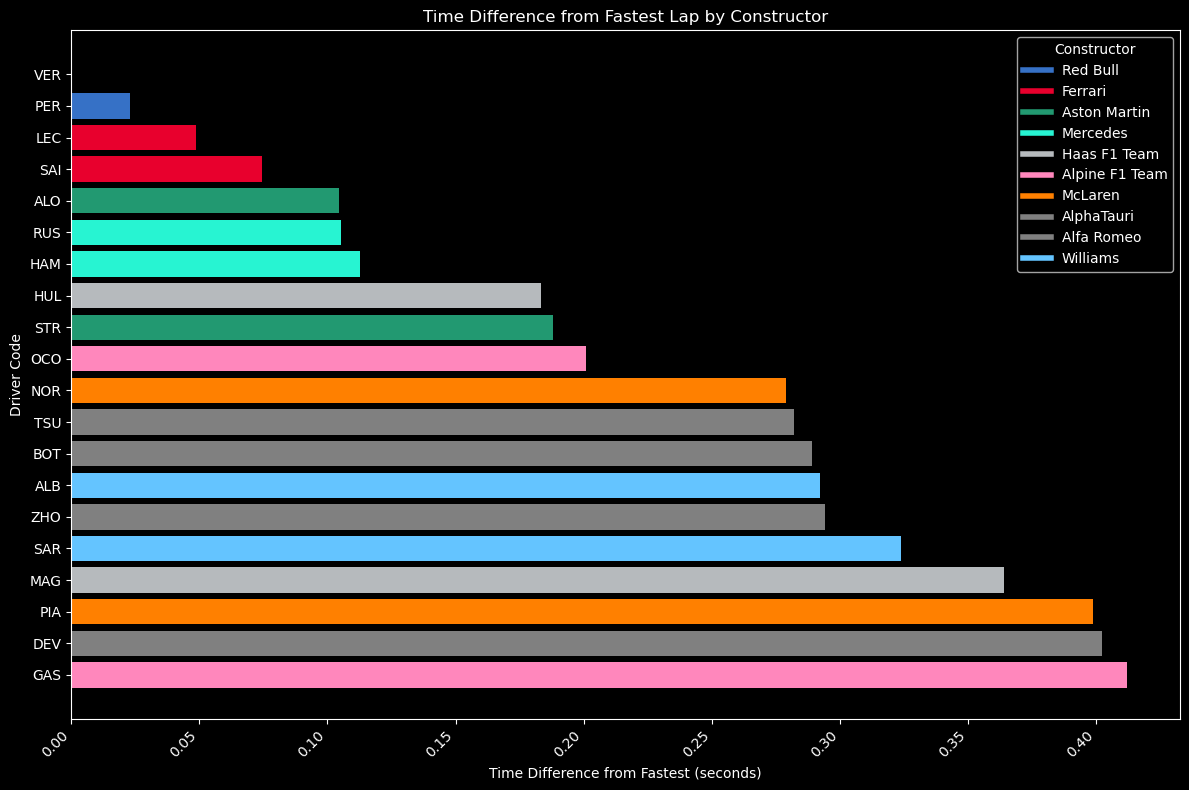

In [5]:
plotQualiDrivers(bahrain_quali)

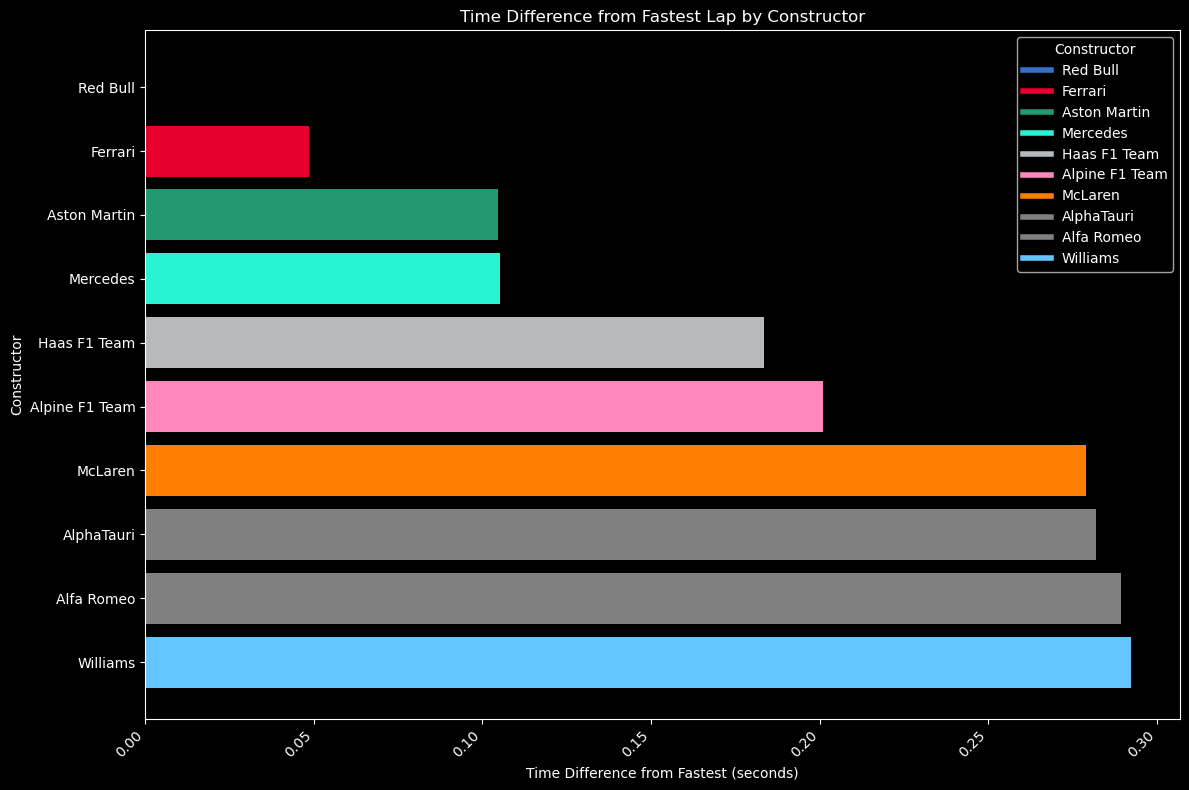

In [6]:
plotQualiConstructors(bahrain_quali)

# Race Analysis

In [7]:
bahrain_gp = getLapTimes("Bahrain Grand Prix", 2022)

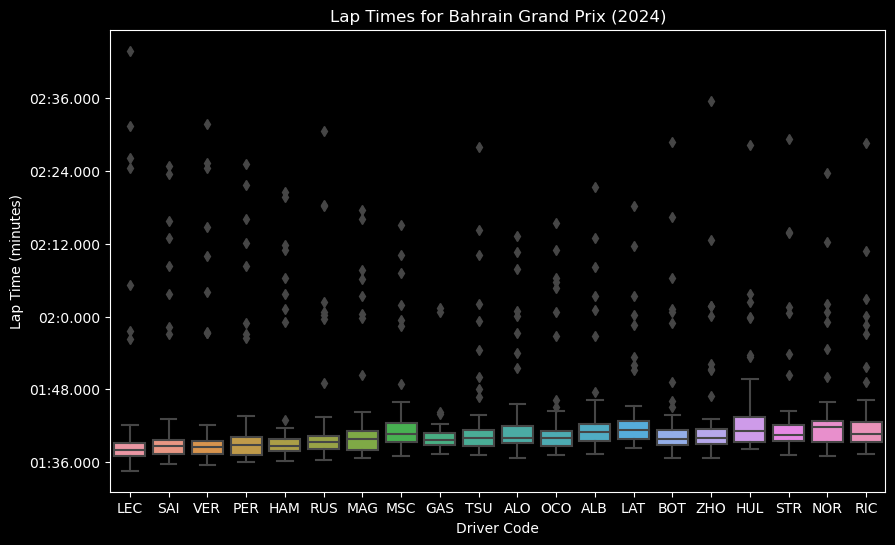

In [8]:
plotLapTimesBoxplot(bahrain_gp)

In [9]:
pit_stops = data['pit_stops']

In [10]:
bahrain_gp_no_pitstops = removePitstopLaps(bahrain_gp, pit_stops)

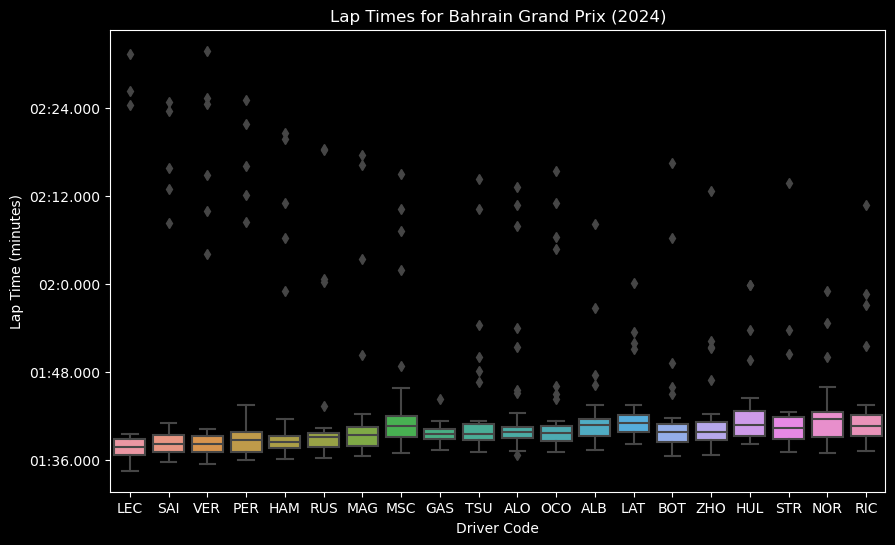

In [11]:
plotLapTimesBoxplot(bahrain_gp_no_pitstops)

In [12]:
# Merge driver names
driver_names = bahrain_gp[['driverId', 'forename', 'surname']].drop_duplicates().set_index('driverId')

In [ ]:
# Calculate and print mean and standard deviation of lap times
mean_lap_time_ms = bahrain_gp['milliseconds'].mean()
std_lap_time_ms = bahrain_gp['milliseconds'].std()
mean_lap_time = convert_to_time_format(mean_lap_time_ms)
std_lap_time = convert_to_time_format(std_lap_time_ms)

Unfiltered data Data:
Mean Lap Time: 1:43.134, Standard Deviation: 0:10.013


(103134.85930543188, 10013.775460576282)

In [14]:
stats = calculateDriverStatistics(bahrain_gp, driver_names)

In [15]:
# Display sorted statistics
stats_subset = stats[['forename', 'surname', 'mean_time', 'std_time']]
stats_subset.sort_values("std_time")

,forename,surname,mean_time,std_time
11,Pierre,Gasly,1:40.781,0:04.704
16,Nicholas,Latifi,1:43.778,0:07.986
18,Mick,Schumacher,1:43.265,0:08.201
1,Fernando,Alonso,1:43.087,0:08.361
13,Lando,Norris,1:43.682,0:08.499
2,Nico,Hülkenberg,1:43.814,0:08.502
15,Alexander,Albon,1:43.640,0:08.808
4,Daniel,Ricciardo,1:43.658,0:08.986
9,Esteban,Ocon,1:43.035,0:09.033
17,Yuki,Tsunoda,1:43.052,0:09.674


In [16]:
# Calculate and print mean and standard deviation of lap times without pitstops
mean_lap_time_ms_no_pitstops = bahrain_gp_no_pitstops['milliseconds'].mean()
std_lap_time_ms_no_pitstops = bahrain_gp_no_pitstops['milliseconds'].std()
mean_lap_time_no_pitstops = convert_to_time_format(mean_lap_time_ms_no_pitstops)
std_lap_time_no_pitstops = convert_to_time_format(std_lap_time_ms_no_pitstops)

In [17]:
stats = calculateDriverStatistics(bahrain_gp_no_pitstops, driver_names)

In [18]:
# Display sorted statistics
stats_subset = stats[['forename', 'surname', 'mean_time', 'std_time']]
stats_subset.sort_values("std_time")

,forename,surname,mean_time,std_time
11,Pierre,Gasly,1:39.646,0:01.253
13,Lando,Norris,1:41.628,0:03.913
16,Nicholas,Latifi,1:41.837,0:04.028
2,Nico,Hülkenberg,1:41.978,0:04.603
15,Alexander,Albon,1:41.569,0:04.795
10,Lance,Stroll,1:41.291,0:05.437
19,Guanyu,Zhou,1:41.013,0:05.632
4,Daniel,Ricciardo,1:41.924,0:05.770
5,Valtteri,Bottas,1:41.061,0:06.673
17,Yuki,Tsunoda,1:41.514,0:07.037


In [19]:
# Comparison Summary
print("\nComparison of Mean Lap Times and Standard Deviations:")
print(f"1. Unfiltered Data      - Mean Lap Time: {mean_lap_time}, Standard Deviation: {std_lap_time}")
print(f"2. Pitstops Removed     - Mean Lap Time: {mean_lap_time_no_pitstops}, Standard Deviation: {std_lap_time_no_pitstops}")


Comparison of Mean Lap Times and Standard Deviations:
1. Unfiltered Data      - Mean Lap Time: 1:43.134, Standard Deviation: 0:10.013
2. Pitstops Removed     - Mean Lap Time: 1:41.606, Standard Deviation: 0:08.132


In [20]:
def calculate_driver_stats(df, label):
    # Group by both driverId and constructor_name
    stats = df.groupby(['driverId', 'name_y'])['milliseconds'].agg(['mean', 'std']).reset_index()
    
    # Rename the columns to include the label
    stats.columns = ['driverId', 'name_y', f'{label}_mean', f'{label}_std']
    
    return stats

In [21]:
# Calculate statistics for each driver (Unfiltered, Filtered, No Pitstops)
unfiltered_stats = calculate_driver_stats(bahrain_gp, 'unfiltered')
no_pitstops_stats = calculate_driver_stats(bahrain_gp_no_pitstops, 'no_pitstops')

# Combine the statistics for comparison
combined_stats = pd.merge(unfiltered_stats, no_pitstops_stats, on=['driverId', 'name_y'])
combined_stats = combined_stats.join(driver_names, on='driverId')
combined_stats = combined_stats[['forename', 'surname', 'name_y', 'unfiltered_mean', 'unfiltered_std', 'no_pitstops_mean', 'no_pitstops_std']]

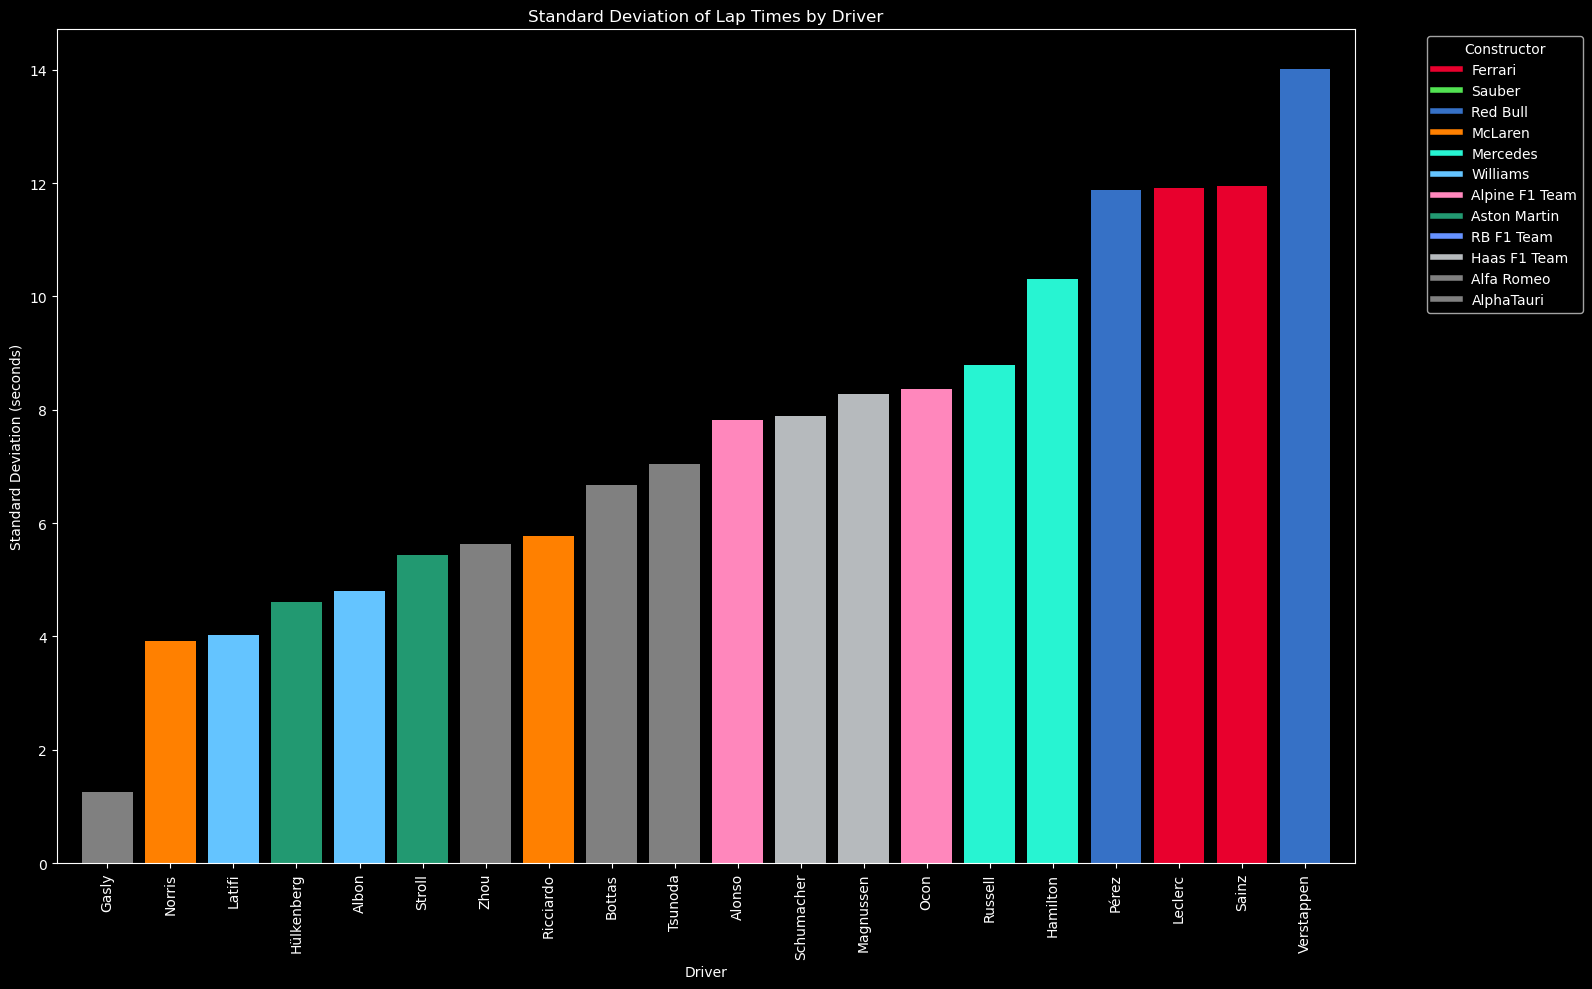

In [22]:
plotStdDevLapTimes(combined_stats, constructor_colors)

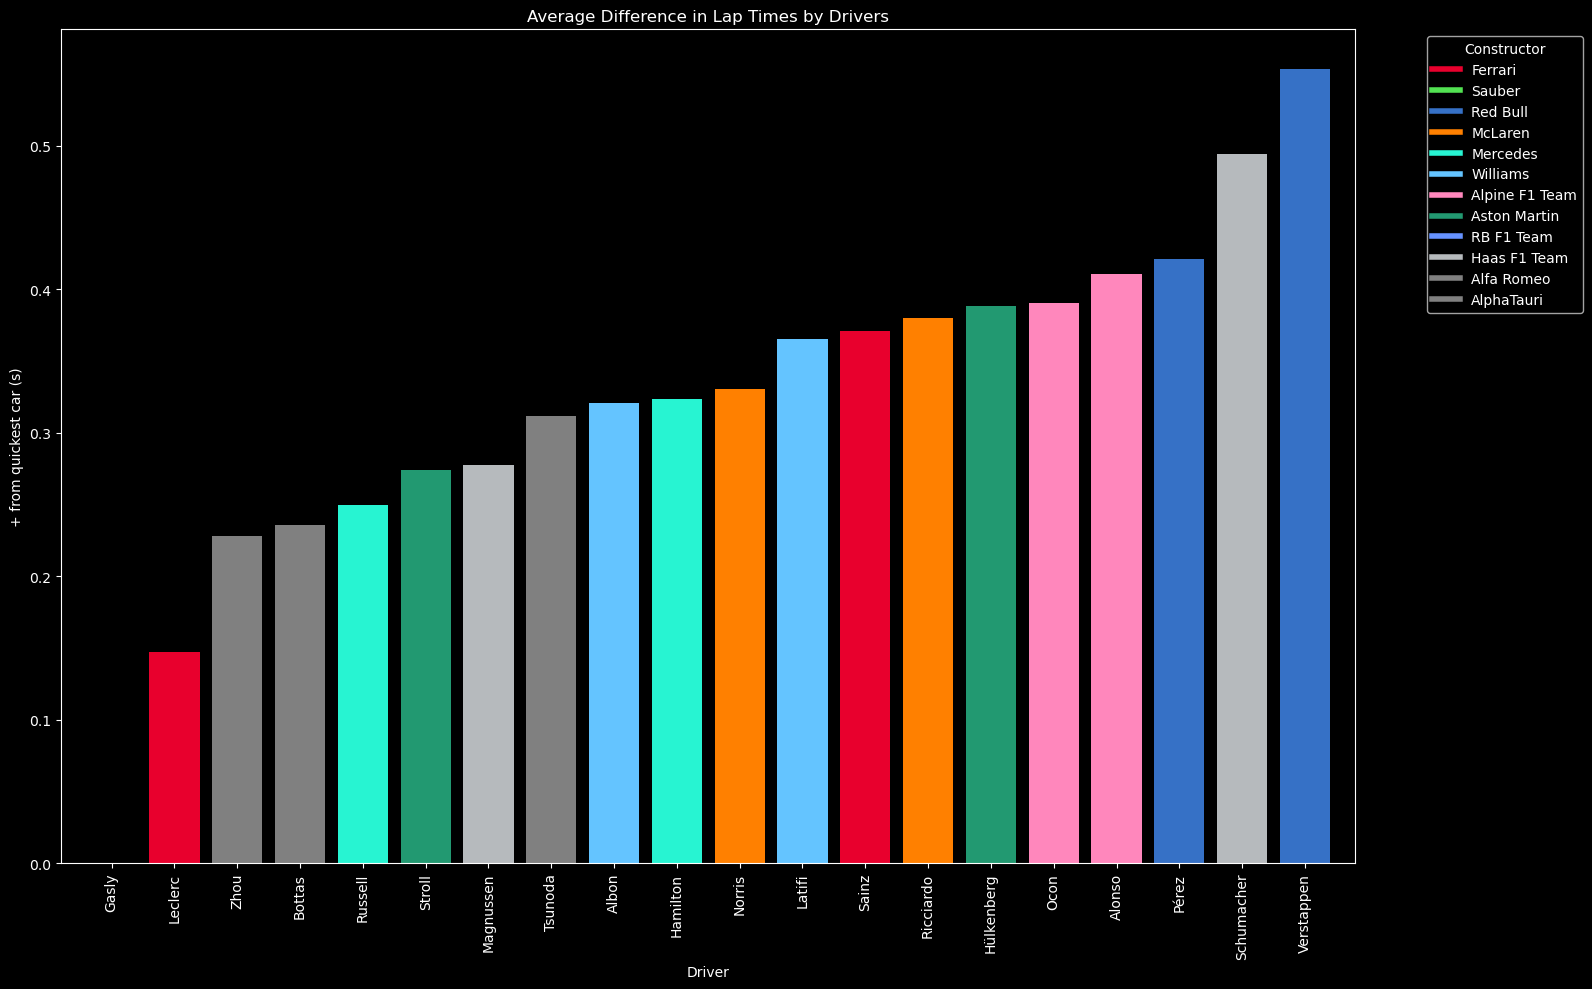

In [23]:
plotMeanLapTimes(combined_stats, constructor_colors)